## Brand over all sentiment on Reddit


In [35]:
import requests
import pandas as pd
import praw
from praw.models import MoreComments

import os
import zipfile
import ast
import re
# Tools for text analysis
# We can use nltk to extract adjective and verbs related to the product/brand 
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords
# Vader sentiment analysis 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from rapidfuzz import process, fuzz
import matplotlib.pyplot as plt

os.makedirs("../output", exist_ok=True)
from dotenv import load_dotenv
load_dotenv()

True

# Comment analysis

The post are searched by keywords using product question and review tag to keep post topic narrowed to specific brand. However, the comment can be mentioning other brand, so to improve the accuracy of sentiment analysis we will be tokenizing the comments.

In [70]:
analyzer = SentimentIntensityAnalyzer() 
comment_df = pd.read_csv("../output/subreddit_comment_data.csv")
all_brands = pd.read_csv("../output/all_brands.csv")
brand_list = all_brands["brand_name"].str.lower().str.strip()
brand_set = set(brand_list)
comment_df


,post_id,title,brand,subreddit_name,comment,cleaned_comment
0,1bv7f30,[Product Question] Estée Lauder ANR - Allergic,Estée Lauder,SkincareAddiction,Return it? Give it to someone?,return give someone
1,1bv7f30,[Product Question] Estée Lauder ANR - Allergic,Estée Lauder,SkincareAddiction,You can try to use it on your chest area to se...,try use chest area see tolerated otherwise wou...
2,psd79w,[Product Question] Estée Lauder Advanced Night...,Estée Lauder,SkincareAddiction,I've used this serum for years and it's one of...,used serum years one favourites use couple dro...
3,psd79w,[Product Question] Estée Lauder Advanced Night...,Estée Lauder,SkincareAddiction,"The more you use, the faster you use it up and...",use faster use sooner replace course company w...
4,psd79w,[Product Question] Estée Lauder Advanced Night...,Estée Lauder,SkincareAddiction,Most serums just need a few drops to cover the...,serums need drops cover face see half dropper ...
...,...,...,...,...,...,...
483,1fx72ac,My review: Glossier Reve perfume,Glossier,Sephora,My friend and I have tried the Glossier perfum...,friend tried glossier perfumes immediately sol...
484,1fx72ac,My review: Glossier Reve perfume,Glossier,Sephora,I agree with you! I thought Reve would be my f...,agree thought reve would favorite two severely...
485,1fx72ac,My review: Glossier Reve perfume,Glossier,Sephora,"I’m hoping I won’t like them tbh, won’t be goo...",hoping like tbh good bank original already cho...
486,1fx72ac,My review: Glossier Reve perfume,Glossier,Sephora,I will also add as a side note: I love Burberr...,also add side note love burberry goddess inten...


In [71]:
brand_mapping = {
    'fenty': 'Fenty Beauty',
    'etude': 'Etude House',
    'e.l.f.': 'e.l.f. Cosmetics'
}

def normalize_brand(name):
    return brand_mapping.get(name.lower().strip(), name.strip())

# Apply to `search_term` column after creating comment_df
comment_df["normalized_brand"] = comment_df["brand"].apply(normalize_brand)

comment_df.head()

,post_id,title,brand,subreddit_name,comment,cleaned_comment,normalized_brand
0,1bv7f30,[Product Question] Estée Lauder ANR - Allergic,Estée Lauder,SkincareAddiction,Return it? Give it to someone?,return give someone,Estée Lauder
1,1bv7f30,[Product Question] Estée Lauder ANR - Allergic,Estée Lauder,SkincareAddiction,You can try to use it on your chest area to se...,try use chest area see tolerated otherwise wou...,Estée Lauder
2,psd79w,[Product Question] Estée Lauder Advanced Night...,Estée Lauder,SkincareAddiction,I've used this serum for years and it's one of...,used serum years one favourites use couple dro...,Estée Lauder
3,psd79w,[Product Question] Estée Lauder Advanced Night...,Estée Lauder,SkincareAddiction,"The more you use, the faster you use it up and...",use faster use sooner replace course company w...,Estée Lauder
4,psd79w,[Product Question] Estée Lauder Advanced Night...,Estée Lauder,SkincareAddiction,Most serums just need a few drops to cover the...,serums need drops cover face see half dropper ...,Estée Lauder


In [72]:

comment_rows = []

# Search for mentioning of brand value ?
# tagging brand to the comment and getting the sentiment score

def brand_word_match(comment):
    # store every word as a a set 
    words = set(re.findall(r'\b\w+\b', comment.lower()))
    exact_matches = words & brand_set
    if exact_matches:
        return exact_matches
    # check for more causal mention of brand 
    found = process.extract(
        query=comment,
        choices=brand_list,
        scorer=fuzz.partial_ratio,
        limit=10
    )
    return {match for match, score, _ in found if score >= 85}


for _, row in comment_df.iterrows():
    target_brand = row["normalized_brand"]
    comment = row["cleaned_comment"]
    
    comment_lower = comment.lower()
    mentioned_brands = brand_word_match(comment_lower)

    if not mentioned_brands or mentioned_brands == {target_brand}:
        sentiment_score = analyzer.polarity_scores(comment)["compound"]
        sentiment_label = (
            "positive" if sentiment_score > 0.05
            else "negative" if sentiment_score < -0.05
            else "neutral"
        )
        comment_rows.append({
            "post_id": row["post_id"],
            "title": row["title"],
            "comment": comment,
            "normalized_brand": target_brand,
            "subreddit": row["subreddit_name"],
            "sentiment_score": sentiment_score,
            "sentiment_label": sentiment_label
        })

comment_df = pd.DataFrame(comment_rows)
print(comment_df.sentiment_label.value_counts())
comment_df.head()

comment_df.to_csv("../output/subreddit_sentiment_data.csv", index=False)

sentiment_label
positive    68
neutral     20
negative    14
Name: count, dtype: int64


   normalized_brand  sentiment_score
0             COSRX         0.125500
1      Estée Lauder         0.339380
2       Etude House         0.482183
3      Fenty Beauty         0.075715
4          Glossier         0.493550
5         Innisfree         0.330954
6           Laneige         0.497050
7         Sulwhasoo         0.596400
8             Tarte         0.613171
9  e.l.f. Cosmetics         0.366286


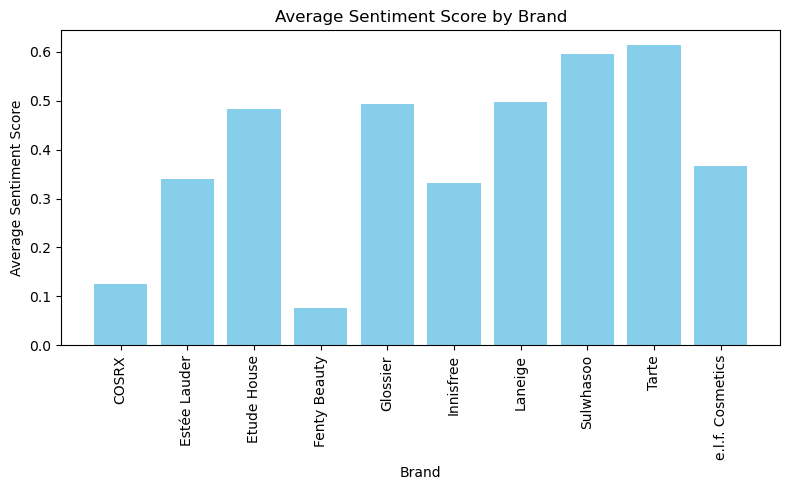

In [73]:
avg_sentiment = comment_df.groupby("normalized_brand")["sentiment_score"].mean().reset_index()

print(avg_sentiment)
plt.figure(figsize=(8, 5))
plt.bar(avg_sentiment["normalized_brand"], avg_sentiment["sentiment_score"], color='skyblue')
plt.xlabel("Brand")
plt.ylabel("Average Sentiment Score")
plt.title("Average Sentiment Score by Brand")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
